# `pandas_datareader`

The purpose of this short tutorial is to introduce the `pandas_datareader` package, and to use it to view some data related to the recent market turmoil resulting from COVID-19. 

In short, `pandas_datareader` is a convenient way to download a variety of online data sources such as Yahoo Finance, Quandl, and the Federal Reserve (FRED).

My graphs do not have proper titles.  The grader will have higher expectations for you for your assignments.

## Loading Packages

Let's begin by loading the packages that we will need.

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## Yahoo Finance - SP500 Volatility

Equity volatility levels, both realized and implied, are at levels similar to the 2008 financial crisis.  However, the overall price decline has been faster.  This is the fastest such decline ever.

When you query multiple symbols from Yahoo, it comes back as a panel object, which I find rather annoying.

In [2]:
df = pdr.get_data_yahoo(['SPY','^VIX'], start='2008-01-01', end='2020-04-06').reset_index()
df.head()

Attributes       Date   Adj Close                  Close             \
Symbols                       SPY       ^VIX         SPY       ^VIX   
0          2008-01-02  112.588051  23.170000  144.929993  23.170000   
1          2008-01-03  112.533707  22.490000  144.860001  22.490000   
2          2008-01-04  109.775894  23.940001  141.309998  23.940001   
3          2008-01-07  109.682663  23.790001  141.190002  23.790001   
4          2008-01-08  107.911469  25.430000  138.910004  25.430000   

Attributes        High                    Low                   Open  \
Symbols            SPY       ^VIX         SPY       ^VIX         SPY   
0           146.990005  24.049999  143.880005  22.400000  146.529999   
1           145.490005  23.270000  144.070007  22.110001  144.910004   
2           143.440002  24.299999  140.910004  23.250000  143.339996   
3           142.229996  24.879999  140.100006  23.299999  141.809998   
4           142.899994  25.600000  138.440002  22.629999  142.080002   

Attributes                  Volume       
Symbols          ^VIX          SPY ^VIX  
0           22.580000  204935600.0  0.0  
1           23.110001  125133300.0  0.0  
2           23.500000  232330900.0  0.0  
3           24.620001  234991000.0  0.0  
4           23.270000  326365700.0  0.0

The following code grabs the `Adj Close` column for all the symbols and then does some wrangling.

In [3]:
df_spy = df['Adj Close'].copy()
df_spy.columns = df_spy.columns.str.lower().str.replace('^', '')
df_spy['trade_date'] = df['Date']
df_spy.head()

Symbols,spy,vix,trade_date
0,112.588051,23.170000,2008-01-02
1,112.533707,22.490000,2008-01-03
2,109.775894,23.940001,2008-01-04
3,109.682663,23.790001,2008-01-07
4,107.911469,25.430000,2008-01-08


Next we calculate daily returns and a rolling 1-month realized volatlity.

In [4]:
df_spy['dly_ret'] = np.log(df_spy['spy']) - np.log(df_spy['spy'].shift(1))
df_spy['realized_vol'] = df_spy['dly_ret'].rolling(21).std() * np.sqrt(252)

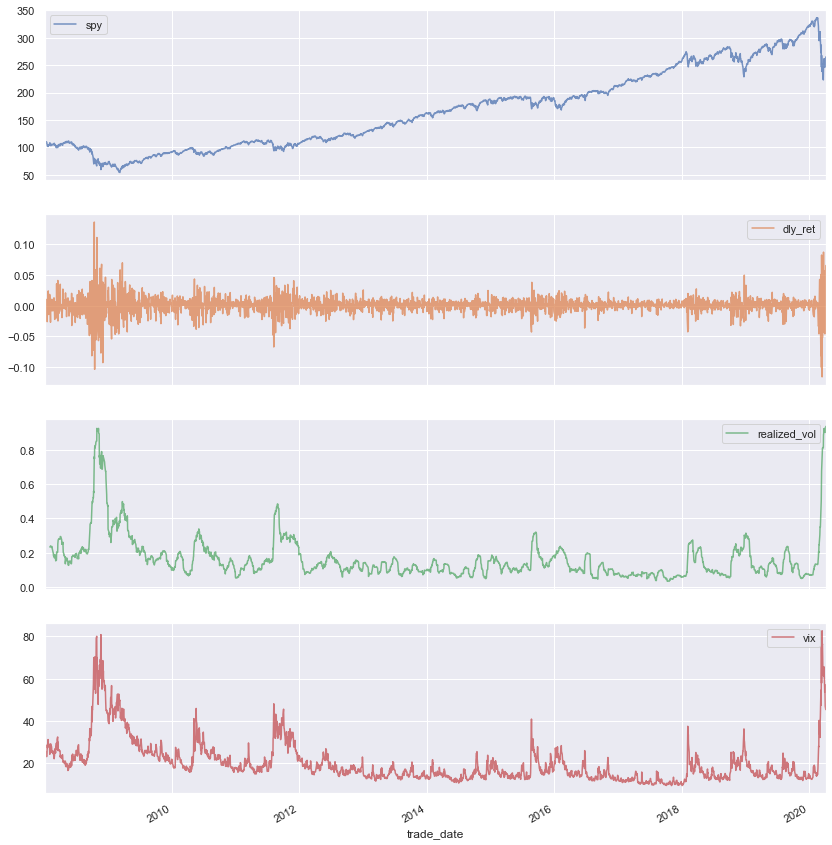

In [5]:
df_spy.plot(x='trade_date', y=['spy', 'dly_ret', 'realized_vol', 'vix'], subplots=True, alpha=0.75, figsize=(14, 16));

## Yahoo Finance: Equities vs REITs

I have a personal interest in REITs, so I want to see how they faired relative to equities.

In [6]:
df = pdr.get_data_yahoo(['SPY','IWM', 'VNQ', 'SCHH'], start='2020-02-18', end='2020-04-06').reset_index()

In [7]:
df_reit = df['Adj Close'].copy()
df_reit.columns = df_reit.columns.str.lower().str.replace('^', '')
df_reit['trade_date'] = df['Date']
df_reit.head()

Symbols,iwm,schh,spy,vnq,trade_date
0,166.894669,48.315693,334.761505,98.679878,2020-02-18
1,167.751358,47.548779,336.362091,97.350258,2020-02-19
2,168.159775,48.166294,334.980225,98.511200,2020-02-20
3,166.456375,48.335613,331.530518,98.798950,2020-02-21
4,161.445755,47.648376,320.535187,97.449486,2020-02-24


The `pd.melt()` function makes a short-wide table, tall and narrow.  This is sometimes called *tidy* data.

In [8]:
df_reit = pd.melt(df_reit, id_vars='trade_date', value_name='adjusted_close').rename(columns={'Symbols':'ticker'})
df_reit.columns = df_reit.columns.str.lower()
df_reit.head()

,trade_date,ticker,adjusted_close
0,2020-02-18,iwm,166.894669
1,2020-02-19,iwm,167.751358
2,2020-02-20,iwm,168.159775
3,2020-02-21,iwm,166.456375
4,2020-02-24,iwm,161.445755


Now that our data is tidy, we can use `.groupby()` to calculate daily returns and cumulative returns for each `ticker`.

In [9]:
df_reit['dly_ret'] = np.log(df_reit.adjusted_close).groupby(df_reit.ticker).diff()
df_reit['cumret'] = df_reit.groupby(['ticker'])['dly_ret'].cumsum()
df_reit.head()

,trade_date,ticker,adjusted_close,dly_ret,cumret
0,2020-02-18,iwm,166.894669,NaN,NaN
1,2020-02-19,iwm,167.751358,0.005120,0.005120
2,2020-02-20,iwm,168.159775,0.002432,0.007552
3,2020-02-21,iwm,166.456375,-0.010181,-0.002630
4,2020-02-24,iwm,161.445755,-0.030564,-0.033194


It looks like REITs have fared worse than equities.  Also notice that on the equity side small-cap got hit bigger than big-cap (IWM vs SPY), which is typical of a sell-off.

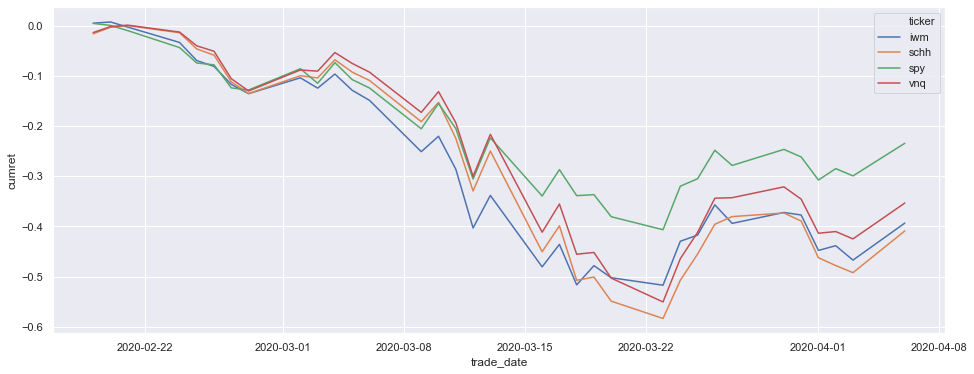

In [10]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_reit, x='trade_date', y='cumret',
                  hue='ticker');

## FRED: Flight to Quality - 10 Year Treasuries

In times of market stress, investor tend to retreat to safe assets such as US Government bonds.  The 10-year treasury rate is at all time lows.

In [11]:
df_treasury = pdr.get_data_fred('DGS10', start='2008-01-01', end='2020-04-06').reset_index()
df_treasury.rename(columns={'DATE':'trade_date', 'DGS10':'treasury_10y',}, inplace=True)
df_treasury.head()

,trade_date,treasury_10y
0,2008-01-01,NaN
1,2008-01-02,3.91
2,2008-01-03,3.91
3,2008-01-04,3.88
4,2008-01-07,3.86


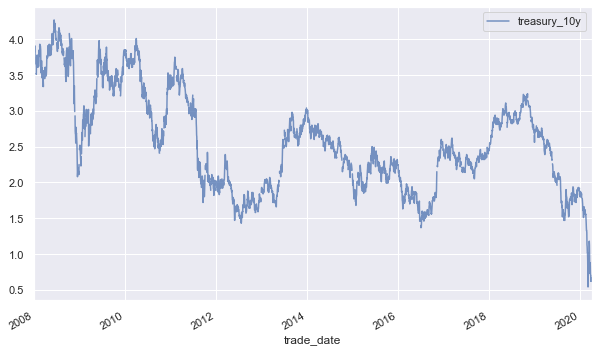

In [12]:
df_treasury.plot(x='trade_date', y=['treasury_10y'], subplots=True, alpha=0.75, figsize=(10, 6));

## FRED: Maubassin's Observation

High yield spreads and the VIX are both indicators of market stress.  In a podcast I recently hear, Michael Maubassin noticed that the VIX reached its 2008 level, by HY did not.  What are your thoughts?

In [13]:
df_high_yield = pdr.get_data_fred('BAMLH0A0HYM2', start='2008-01-01', end='2020-04-06').reset_index()
df_high_yield.rename(columns={'DATE':'trade_date', 'BAMLH0A0HYM2':'hy_spread',}, inplace=True)
df_high_yield.head()

,trade_date,hy_spread
0,2008-01-01,NaN
1,2008-01-02,6.10
2,2008-01-03,6.17
3,2008-01-04,6.36
4,2008-01-07,6.45


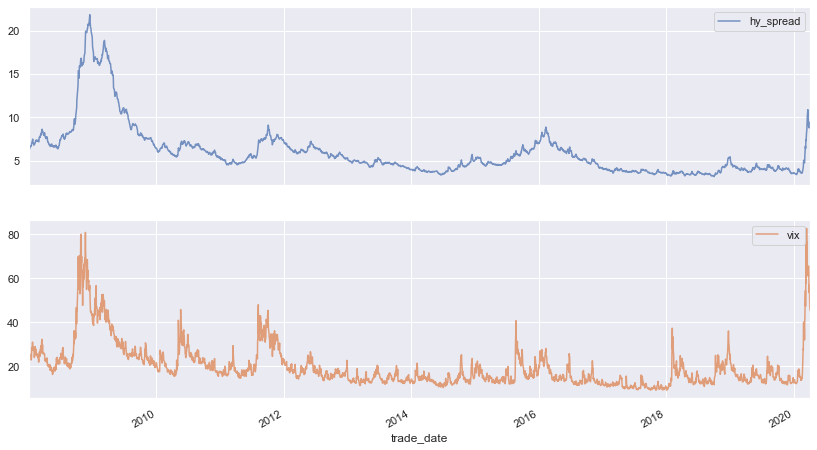

In [14]:
(
df_spy[['trade_date', 'vix']]
    .merge(df_high_yield, on='trade_date')
    .plot(x='trade_date', y=['hy_spread', 'vix'], subplots=True, alpha=0.75, figsize=(14, 8))
);

## Quandl: Priced to Perfection

One of the reasons for the quick sell-off was that business valuations were high by historical standards, but not at record levels.

Here is the code to graph the data from Quandl.  If you want to use Quandle, you will need to open an account (which is free) to get an API key.

In [15]:
# df_pe = \
#     pdr.DataReader(
#         name = 'MULTPL/SHILLER_PE_RATIO_MONTH',
#         start='1990-01-01', end='2020-04-07',
#         data_source='quandl'
#         ,api_key='YOUR_API_KEY'
#     ).reset_index().rename(columns={'Date':'trade_date', 'Value':'pe_ratio'})
# df_pe.to_csv('quandl_pe_ratio.csv', index = False)

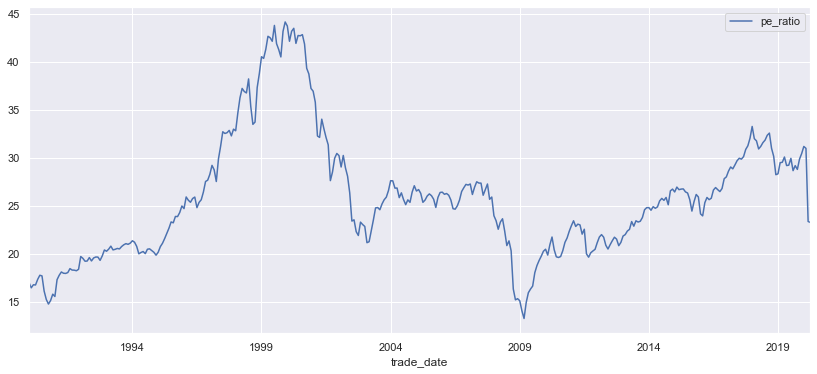

In [16]:
df_pe = pd.read_csv('quandl_pe_ratio.csv')
df_pe['trade_date'] = pd.to_datetime(df_pe['trade_date'])
(
df_pe
    .assign(year = df_pe.trade_date.dt.year)
    .assign(month = df_pe.trade_date.dt.month)
    .groupby(['year', 'month'])[['trade_date']].min().reset_index()
    .merge(df_pe, on='trade_date')
    .plot(x='trade_date', y=['pe_ratio'], figsize=(14, 6))
);